In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from kalman import Kalman, LDS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def run_lds_kf(lds, kf, steps, u=0):
    """Run an experiment with a linear dynamical system and a Kalman filter"""
    lds_x = np.zeros((steps, lds.state_dimensions))
    lds_y = np.zeros((steps, lds.output_dimensions))
    kf_xhat = np.zeros((steps, lds.state_dimensions))
    kf_p = np.zeros((steps, lds.state_dimensions, lds.state_dimensions))
    kf_k = np.zeros((steps, lds.state_dimensions, lds.output_dimensions))
    for step in range(steps):
        lds_x[step, :], lds_y[step, :] = lds.step(u)
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, lds_y[step, :])
    lds_data = (lds_x, lds_y)
    kf_data = (kf_xhat, kf_p, kf_k)
    return lds_data, kf_data

def plot_lds_kf_1d(lds_data, kf_data):
    fig, axs = plt.subplots(nrows=3, figsize=(8, 6))
    x, y = lds_data
    xhat, p, k = kf_data
    axs[0].plot(x, 'k', label="truth")
    axs[0].plot(y, '+', label="measurements")
    axs[0].plot(xhat, 'k--', label="estimate")
    axs[0].legend(bbox_to_anchor=(1,0.5), loc="center left")
    axs[1].plot(p, label="P")
    axs[1].legend(loc="upper right")
    axs[2].plot(k, label="K")
    axs[2].legend(loc="upper right")
    

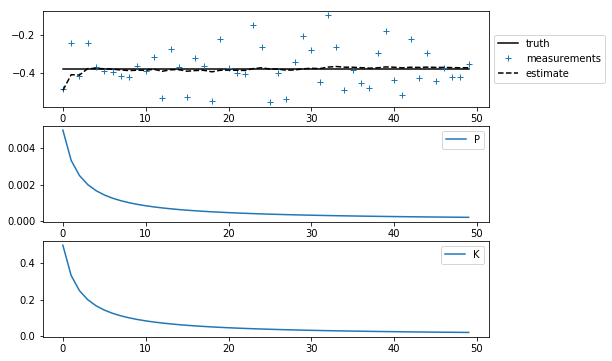

In [23]:
# 1d constant dynamics, no noise
def replicate_introduction():
    """Test that the Kalman filter works on a 1D constant system with no noise"""
    A = np.array([[1]]) # no dynamics, system constant
    B = np.array([[0]]) # no input
    C = np.array([[1]]) # measure state directly
    Q = np.array([[0]]) # no process noise
    R = np.array([[0.01]])
    x0 = np.array([-0.37727])
    xhat0 = np.array([-0.5])
    Phat0 = np.array([0.01])

    N_STEPS = 50

    x = np.zeros(N_STEPS) + x0 # underlying state
    z = np.random.normal(scale=np.sqrt(R[0]), size=N_STEPS) + x # measured state
    
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    kf_xhat = np.zeros((N_STEPS, 1))
    kf_p = np.zeros((N_STEPS, 1))
    kf_k = np.zeros((N_STEPS, 1))
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    lds_data = (x, z)
    kf_data = (kf_xhat, kf_p, kf_k)
    plot_lds_kf_1d(lds_data, kf_data)
    
replicate_introduction()

In [19]:
# 1d constant dynamics, measure noise
# 1d constant dynamics, process noise
# 1d constant dynamics, process + measure noise

# 1d constant dyanmics, process + measure noise